<a href="https://colab.research.google.com/github/Hoang-it/orhcid_classification/blob/main/sof/sof_fast_rcnn_resnet50_fpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:14:02tcmalloc: large alloc 1147494400 bytes == 0x5575f8664000 @  0x7f9a40707615 0x5575be2494cc 0x5575be32947a 0x5575be24c2ed 0x5575be33de1d 0x5575be2bfe99 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bfd00 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bc737 0x5575be33ec66 0x5575be2bbdaf 0x5575be33ec66 0x5575be2bbdaf 0x5575be33ec66 0x5575be2bbdaf 0x5575be24e039 0x5575be291409 0x5575be24cc52 0x5575be2bfc25 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bc737 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bb915 0x5575be24dafa 0x5575be2bbc0d 0x5575be2ba9ee
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:25tcmalloc: large alloc 1434370048 bytes == 0x55763ccba000 @  0x7f9a40707615 0x5575be2494cc 0x5575be32947a 0x5575be24c2ed 0x5575be33de1d 0x5575be2bfe99 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bfd00 0x5575be2ba9ee 0x5575be24dbda 0x5575be2bc737 0x5575be33ec66 0x5575be2bbd

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.8.0+cu111 True
0.17.0


In [14]:
# !mkdir checkpoints
!gdown --id 1qsaRBG-IbHJVTsXAZUK3-X66d95mY8Dr

Downloading...
From: https://drive.google.com/uc?id=1RiRLglta9IewrR8Y7wqx8ZtDmdUSNi8M
To: /content/mmsegmentation/checkpoints/18092021_dataset.zip
4.23MB [00:00, 31.2MB/s]


In [11]:
!mv /content/mmsegmentation/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth /content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth

pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [12]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [16]:
%cd ..
!gdown --id 1RiRLglta9IewrR8Y7wqx8ZtDmdUSNi8M 

/content/mmsegmentation
Downloading...
From: https://drive.google.com/uc?id=1RiRLglta9IewrR8Y7wqx8ZtDmdUSNi8M
To: /content/mmsegmentation/18092021_dataset.zip
4.23MB [00:00, 66.9MB/s]


In [19]:
!mkdir dataset
!unzip /content/mmsegmentation/18092021_dataset.zip -d dataset

Archive:  /content/mmsegmentation/18092021_dataset.zip
 extracting: dataset/images/25.jpg   
 extracting: dataset/images/69.jpg   
 extracting: dataset/images/70.jpg   
 extracting: dataset/images/73.jpg   
 extracting: dataset/images/66.jpg   
 extracting: dataset/images/29.jpg   
 extracting: dataset/images/84.jpg   
 extracting: dataset/images/26.jpg   
 extracting: dataset/images/74.jpg   
 extracting: dataset/images/32.jpg   
 extracting: dataset/images/91.jpg   
 extracting: dataset/images/76.jpg   
 extracting: dataset/images/48.jpg   
 extracting: dataset/images/37.jpg   
 extracting: dataset/images/71.jpg   
 extracting: dataset/images/22.jpg   
 extracting: dataset/images/99.jpg   
 extracting: dataset/images/62.jpg   
 extracting: dataset/images/27.jpg   
 extracting: dataset/images/96.jpg   
 extracting: dataset/images/39.jpg   
 extracting: dataset/images/77.jpg   
 extracting: dataset/images/46.jpg   
 extracting: dataset/images/31.jpg   
 extracting: dataset/images/34.jp

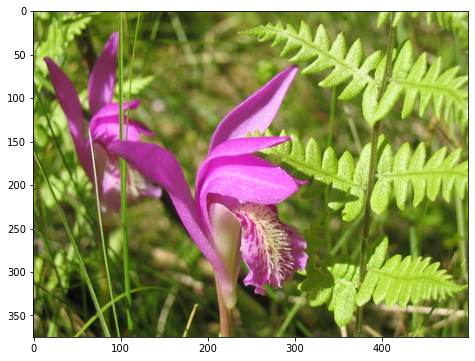

In [18]:
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/mmsegmentation/images/100.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [22]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

dataDir='/content/mmsegmentation/dataset'
dataType='default'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
labels_dir = '/content/mmsegmentation/dataset/labels'


if os.path.exists(labels_dir):
  files = glob.glob(labels_dir + '/*')
  for f in files:
      os.remove(f)
else:
  try:
      os.makedirs(labels_dir, exist_ok = True)
      print("Directory '%s' created successfully" %labels_dir)
  except OSError as error:
      print("Directory '%s' can not be created")

# initialize the COCO api for instance annotations
coco=COCO(annFile)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

# get all images containing given categories, select one at random
filterClasses = ['orchid']
catIds = coco.getCatIds(catNms=filterClasses)
imgIds = coco.getImgIds(catIds=catIds)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
len_imgs = len(imgIds)
print("Number of images containing all required classes:", len(imgIds))
      
exception_files = []

input_img_paths = []
target_img_paths = []

for imgId in range(len_imgs):
  img = coco.loadImgs(imgIds[imgId])[0]
  file_name = img['file_name']
  file_path = '{}/images/{}'.format(dataDir, file_name)
  save = True

  # I = io.imread('{}/images/{}/{}'.format(dataDir, dataType, file_name))/255.0
  I = io.imread(file_path)/255.0

  annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
  anns = coco.loadAnns(annIds)
  # coco.showAnns(anns)

  mask = np.zeros((img['height'],img['width']))


  for i in range(len(anns)):
      className = getClassName(anns[i]['category_id'], cats)
      pixel_value = filterClasses.index(className)+1
      try:          
        mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)      
        
      except:
        print("An exception occurred with file : {}".format(file_name))
        exception_files.append('/content/mmsegmentation/dataset/images/' + file_name)
        save = False
  if save:
    mask_path = '{}/{}.regions'.format(labels_dir, file_name.split('.')[0])
    np.savetxt(mask_path, mask, fmt='%d', delimiter=' ')
    input_img_paths.append(file_path)
    target_img_paths.append(mask_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images containing all required classes: 80


In [26]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/mmsegmentation/dataset'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('background', 'orchid')
palette = [[128, 128, 128], [129, 127, 38]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions', 
                                                         '.png')))

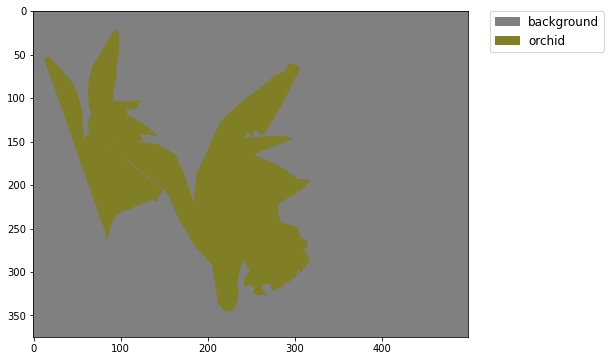

In [28]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/mmsegmentation/dataset/labels/100.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [29]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [30]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class OrchidDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

In [31]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [32]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'OrchidDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [33]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:324: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-09-18 16:46:11,216 - mmseg - INFO - Loaded 64 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2021-09-18 16:46:16,476 - mmseg - INFO - Loaded 16 images
2021-09-18 16

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 16/16, 9.3 task/s, elapsed: 2s, ETA:     0s

2021-09-18 16:47:38,463 - mmseg - INFO - per class results:
2021-09-18 16:47:38,465 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.59 | 97.99 |
|   orchid   | 76.59 | 85.49 |
+------------+-------+-------+
2021-09-18 16:47:38,466 - mmseg - INFO - Summary:
2021-09-18 16:47:38,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.15 | 86.09 | 91.74 |
+-------+-------+-------+
2021-09-18 16:47:38,469 - mmseg - INFO - Iter(val) [16]	aAcc: 0.9615, mIoU: 0.8609, mAcc: 0.9174, IoU.background: 0.9559, IoU.orchid: 0.7659, Acc.background: 0.9799, Acc.orchid: 0.8549


/content/mmsegmentation/mmseg/models/segmentors/base.py:257: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

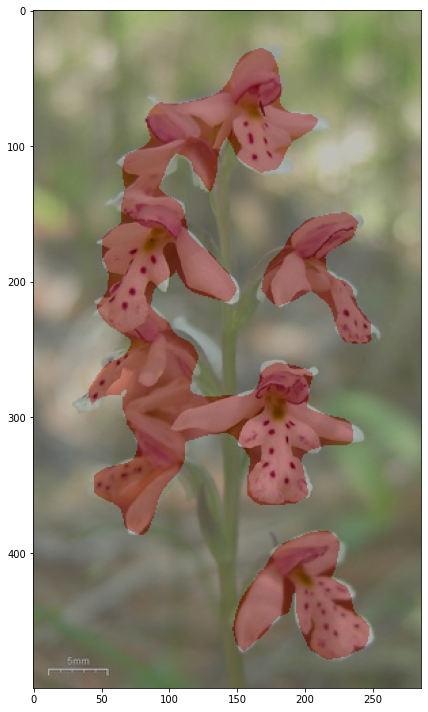

In [39]:
img = mmcv.imread('/content/mmsegmentation/dataset/images/26.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
palette = [[128, 128, 128], [128,0,0]]
show_result_pyplot(model, img, result, palette)